In [49]:
% matplotlib inline
from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel
from astropy.coordinates import SkyCoord

# Matplotlib related
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 

# Extinction
import mwdust

from specutils import extinction

In [7]:
ls

NGC5286_a_1.aux.fits   NGC6522_a_1_sl.txt     mius_ku13_full.base
NGC5286_a_1.fits       NGC6528_c_1.aux.fits   plotAll.pro
NGC5286_a_1_fA.eps     NGC6528_c_1.fits       plotAll_gc.pro
NGC5286_a_1_fA.fits    NGC6528_c_1_fA.eps     prep_gc_spec.ipynb
NGC5286_a_1_fA.out     NGC6528_c_1_fA.fits    sdss_test.lis
NGC5286_a_1_fA.png     NGC6528_c_1_fA.out     slPlot.pro
NGC5286_a_1_fA.spec    NGC6528_c_1_fA.png     sl_fast.config
NGC5286_a_1_sl.txt     NGC6528_c_1_fA.spec    sl_gc_fast.config
NGC6522_a_1.aux.fits   NGC6528_c_1_sl.txt     sl_gc_mask.lis
NGC6522_a_1.fits       Starlight_v04_Mac.exe* sl_gc_test_fA.in
NGC6522_a_1_fA.eps     hs_index_plot_air.lis  sl_mask1.lis
NGC6522_a_1_fA.fits    mastertable.pdf        sl_mask2.lis
NGC6522_a_1_fA.out     miles_ku13_afe.base    sl_slow.config
NGC6522_a_1_fA.png     miles_un13_afe.base
NGC6522_a_1_fA.spec    mius_ku13.base


In [51]:
for name in ['NGC5286_a_1', 'NGC6522_a_1', 'NGC6528_c_1']:
    # Name of the file
    spec = name + '.fits'
    aux = name + '.aux.fits'

    # Read in data
    flux = fits.open(spec)[0].data
    head = fits.open(spec)[0].header 
    saux = fits.open(aux)[0].data
    
    # Read in aux data
    band1 = saux[0,:]
    band2 = saux[1,:]
    band3 = saux[2,:]
    band4 = saux[3,:]

    # Reconstruct wavelength
    naxis1 = head['NAXIS1']
    crval1 = head['CRVAL1']
    crpix1 = head['CRPIX1']
    cdelt1 = head['CDELT1']
    
    wave = np.arange(naxis1) * cdelt1 + crval1
    waveNew = np.arange(3200) * 0.8 + 3500.0
    
    # Galactic extinction
    coord = SkyCoord(head['RA'], head['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
    gall, galb = coord.galactic.l.degree, coord.galactic.b.degree 
    ext = mwdust.SFD()
    r_v = ext(gall, galb, 1.0)[0]
    redden = 10.0 ** (0.4 * extinction.extinction(wave * u.Angstrom, r_v * 3.1, r_v=3.1, model='d03'))
    flux *= redden
    
    # Error spectra
    svar = (band1 / band4)
    serr = (flux / (band4 / 10.0)) 

    # Interpolate the spectra to new wavelength array
    intrp = interp1d(wave, flux, kind='slinear', bounds_error=False)
    fluxNew = intrp(waveNew)

    intrp = interp1d(wave, serr, kind='slinear', bounds_error=False)
    serrNew = intrp(waveNew)

    intrp = interp1d(wave, band1, kind='slinear', bounds_error=False)
    band1New = intrp(waveNew)

    intrp = interp1d(wave, band3, kind='slinear', bounds_error=False)
    band3New = intrp(waveNew)

    # Build a mask
    mask = np.asarray([((band3 / band1) >= 0.5) & (serr <= 0.0)], dtype=int)
    maskNew = np.asarray([((band3New / band1New) >= 0.49) & (serrNew <= 0.02)], dtype=int)[0]
    
    # Build a Table
    sl = Table()

    sl.add_column(Column(waveNew, name='wave'))
    sl.add_column(Column(fluxNew * 1.0E15, name='flux'))
    sl.add_column(Column(serrNew * 1.0E15, name='err'))
    sl.add_column(Column(maskNew, name='mask'))
    
    # Save the table
    sl.write(name + '_sl.txt', format='ascii.fixed_width_no_header')

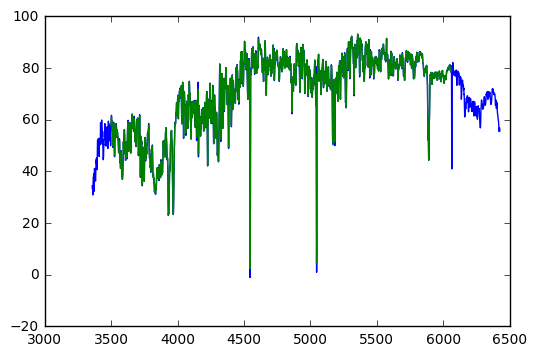

In [52]:
plt.plot(wave, flux * 1.0E15)
plt.plot(waveNew, fluxNew * 1.0E15)

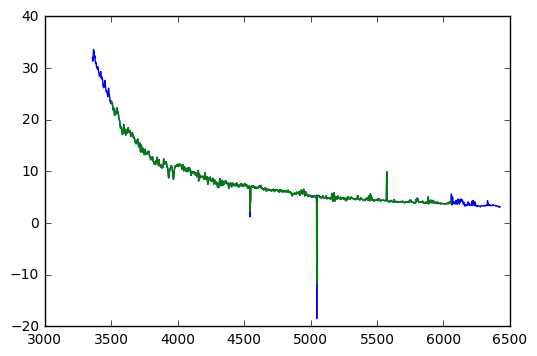

In [53]:
plt.plot(wave, serr * 1.0E15)
plt.plot(waveNew, serrNew * 1.0E15)

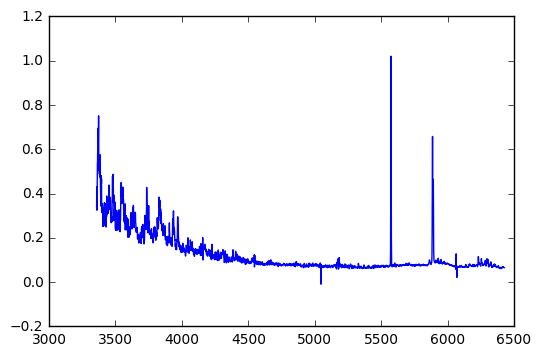

In [54]:
plt.plot(wave, band3 / band1)